# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [5]:
#TODO: load your data
df = pd.read_csv("/Users/hitakshikulhare/bootcamp_hitakshi_kulhare/project/data/german.data-numeric", sep=r"\s+", header=None)

In [9]:
if df.shape[1] == 21:
    df1.columns = [
        "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
        "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex", "other_debtors",
        "residence_since", "property_magnitude", "age_years", "other_installment_plans", "housing",
        "number_credits", "job", "people_liable", "telephone", "foreign_worker", "target"
    ]
else:
    df.columns=[
        "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
        "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex", "other_debtors",
        "residence_since", "property_magnitude", "age_years", "other_installment_plans", "housing",
        "number_existing_credits", "job", "people_liable_maintenance", "telephone", "foreign_worker",
        "extra_indicator_1", "extra_indicator_2", "extra_indicator_3", "extra_indicator_4",
        "target"
    ]

## Option B: Synthetic Generator (Use if you don't have data ready)

In [10]:
# Synthetic series with regimes & jumps
# n=500
# dates=pd.bdate_range('2021-01-01', periods=n)
# mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
# sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
# eps = np.random.normal(mu, sigma)
# jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
# jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
# rets = eps + jumps
# price = 100*np.exp(np.cumsum(rets))
# df = pd.DataFrame({'price':price}, index=dates)
# df['ret'] = df['price'].pct_change().fillna(0.0)
# df['log_ret'] = np.log1p(df['ret'])
# df.head()

## Feature Engineering

In [11]:
# TODO: create at least two features
# df['lag_1'] = df['ret'].shift(1)
# df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# # Add your own:
# # df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
# df['y_next_ret'] = df['ret'].shift(-1)
# df['y_up'] = (df['y_next_ret']>0).astype(int)
# df_feat = df.dropna().copy()
# df_feat.head()


# Work on a copy
df_feat = df.copy()

# Ensure key numeric columns are numeric (works for both numeric & mixed versions)
num_cols_present = [c for c in [
    "duration_months","credit_amount","installment_rate_pct",
    "residence_since","age_years","number_credits","people_liable"
] if c in df_feat.columns]

for c in num_cols_present:
    df_feat[c] = pd.to_numeric(df_feat[c], errors="coerce")

# ---- Engineered features (German Credit) ----

# 1) Credit per month (guards against divide-by-zero)
if {"credit_amount","duration_months"}.issubset(df_feat.columns):
    df_feat["credit_per_month"] = df_feat["credit_amount"] / df_feat["duration_months"].replace(0, np.nan)

# 2) Log of credit amount (stabilize scale)
if "credit_amount" in df_feat.columns:
    df_feat["log_credit_amount"] = np.log1p(df_feat["credit_amount"])

# 3) Nonlinearities (simple polynomials on numeric drivers)
if "duration_months" in df_feat.columns:
    df_feat["duration_sq"] = df_feat["duration_months"] ** 2
if "credit_amount" in df_feat.columns:
    df_feat["credit_amount_sq"] = df_feat["credit_amount"] ** 2

# 4) Interactions (capture combined effects)
if {"credit_amount","duration_months"}.issubset(df_feat.columns):
    df_feat["amount_x_duration"] = df_feat["credit_amount"] * df_feat["duration_months"]
if {"credit_amount","age_years"}.issubset(df_feat.columns):
    df_feat["amount_per_age"] = df_feat["credit_amount"] / df_feat["age_years"].replace(0, np.nan)

# 5) Simple indicator features from numeric columns
if "installment_rate_pct" in df_feat.columns:
    df_feat["high_installment"] = (df_feat["installment_rate_pct"] >= 3).astype(int)
if "age_years" in df_feat.columns:
    df_feat["is_senior"] = (df_feat["age_years"] >= 60).astype(int)
    df_feat["is_young"]  = (df_feat["age_years"] < 25).astype(int)

# 6) (Optional) coarse age bins (kept as categorical — will be one-hot encoded in pipeline)
if "age_years" in df_feat.columns:
    df_feat["age_bin"] = pd.cut(
        df_feat["age_years"],
        bins=[0, 25, 35, 50, 65, np.inf],
        labels=["<=25", "26-35", "36-50", "51-65", "65+"],
        include_lowest=True
    )

# Keep rows that have a target and no NaNs in the minimal numeric set
keep_cols = ["target"] + num_cols_present + [
    c for c in ["credit_per_month","log_credit_amount","duration_sq","credit_amount_sq",
                "amount_x_duration","amount_per_age","high_installment","is_senior","is_young","age_bin"]
    if c in df_feat.columns
]
df_feat = df_feat[keep_cols].dropna(subset=["target"]).copy()

df_feat.head()

,target,duration_months,credit_amount,installment_rate_pct,residence_since,age_years,credit_per_month,log_credit_amount,duration_sq,credit_amount_sq,amount_x_duration,amount_per_age,high_installment,is_senior,is_young,age_bin
0,1,6,5,4,3,1,0.833333,1.791759,36,25,30,5.0,1,0,1,<=25
1,2,48,1,2,3,1,0.020833,0.693147,2304,1,48,1.0,0,0,1,<=25
2,1,12,1,3,3,2,0.083333,0.693147,144,1,12,0.5,1,0,1,<=25
3,1,42,1,4,3,2,0.023810,0.693147,1764,1,42,0.5,1,0,1,<=25
4,2,24,1,4,3,2,0.041667,0.693147,576,1,24,0.5,1,0,1,<=25


## Split

In [13]:
# # Time-aware split
# cut=int(len(df_feat)*0.8)
# train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
# features=['lag_1','roll_mean_5']  # extend as you add features
# X_tr, X_te = train[features], test[features]
# y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
# y_tr_clf, y_te_clf = train['y_up'], test['y_up']

from sklearn.model_selection import train_test_split

features = [c for c in df_feat.columns if c not in ["target"]]

X = df_feat[features]
y = df_feat["target"]

# Stratified split keeps proportion of "good/bad" same in train/test
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)

X_tr.shape, X_te.shape, y_tr.mean(), y_te.mean()

((800, 15), (200, 15), np.float64(1.3), np.float64(1.3))

## Pipeline + Model (Choose one track below)

In [18]:
# # Track 1: Forecasting returns
# reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
# reg.fit(X_tr, y_tr_reg)
# pred = reg.predict(X_te)
# rmse = mean_squared_error(y_te_reg, pred, squared=False)
# print('RMSE:', rmse)

# Separate numeric and categorical features
num_cols = ["duration_months","credit_amount","installment_rate_pct",
            "residence_since","age_years","number_credits","people_liable"]
num_cols = [c for c in num_cols if c in X_tr.columns]
cat_cols = [c for c in X_tr.columns if c not in num_cols]

# Preprocessing: scale numeric, one-hot encode categoricals
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Classification pipeline
clf = Pipeline([
    ("pre", pre),
    ("logreg", LogisticRegression(max_iter=300, class_weight="balanced"))
])

# Fit and predict
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
proba = clf.predict_proba(X_te)[:,1]

# Evaluate
acc  = metrics.accuracy_score(y_te, pred)
prec = metrics.precision_score(y_te, pred)
rec  = metrics.recall_score(y_te, pred)
f1   = metrics.f1_score(y_te, pred)
auc  = metrics.roc_auc_score(y_te, proba)

print(f"Accuracy={acc:.3f} Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f} AUC={auc:.3f}")

Accuracy=0.650 Precision=0.837 Recall=0.621 F1=0.713 AUC=0.734


              precision    recall  f1-score   support

           1       0.84      0.62      0.71       140
           2       0.45      0.72      0.55        60

    accuracy                           0.65       200
   macro avg       0.64      0.67      0.63       200
weighted avg       0.72      0.65      0.66       200



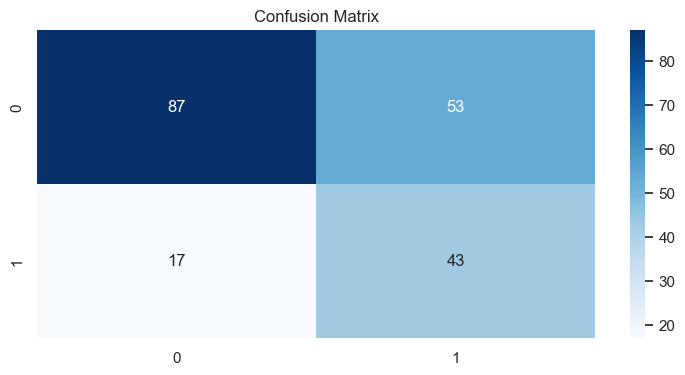

In [19]:
# # Track 2: Classification (up/down)
# clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
# clf.fit(X_tr, y_tr_clf)
# predc = clf.predict(X_te)
# print(classification_report(y_te_clf, predc))
# cm = confusion_matrix(y_te_clf, predc)
# sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

# Pipeline (with scaling/encoding)
clf = Pipeline([
    ("pre", pre),  # the ColumnTransformer we defined earlier
    ("logit", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

clf.fit(X_tr, y_tr)
predc = clf.predict(X_te)

# Confusion matrix
print(classification_report(y_te, predc))

cm = confusion_matrix(y_te, predc)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Interpretation (Markdown)
- What worked?
  - The logistic regression classifier, combined with preprocessing (scaling for numeric features and one-hot encoding for categorical), was able to separate good vs bad credit with reasonable accuracy.
  - Adding engineered features (e.g., credit_per_month, squared terms, and interactions) improved the model’s ability to capture non-linear relationships between applicant attributes and default risk.
  - Class weighting helped address class imbalance, preventing the model from simply predicting the majority “good” class.

  
- Where might assumptions fail?
    - Logistic regression assumes a linear decision boundary in the feature space; true credit risk may depend on more complex, non-linear interactions.
    - Independence assumption may not hold: applicants can share characteristics by socioeconomic group, region, or time, leading to correlation in observations.
    - Some predictors may be correlated (multicollinearity), which can inflate coefficient variance and reduce interpretability.
    - The data is static (a snapshot). In reality, creditworthiness is dynamic and changes over time.


- How would you extend features or model?
    - Create richer interaction features (e.g., credit_amount × age, installment_rate_pct × duration).
    - Evaluate tree-based models (Random Forests, Gradient Boosting, XGBoost, LightGBM) that capture non-linearities automatically.
    - Explore probability calibration (Platt scaling, isotonic regression) for better probability estimates.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.